In [31]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))
import warnings
warnings.filterwarnings('ignore')

In [211]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cycler import cycler

cmap=plt.cm.tab10
c = cycler('color', cmap(np.linspace(0,1,10)))
plt.rcParams["axes.prop_cycle"] = c

#%config InlineBackend.figure_format = 'retina'
%matplotlib notebook

from sodapy import Socrata
import folium
import json

import qgrid
qgrid.enable()

# from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
# init_notebook_mode(connected=True)
# cf.set_config_file(offline=True, world_readable=False, theme='pearl')
# import cufflinks as cf

import utils

In [7]:
%matplotlib notebook
%matplotlib notebook

In [ ]:
# temp = pd.read_html('https://www.wunderground.com/history/airport/KJFK/2014/1/2/DailyHistory.html')[0].iloc[1].iloc[2]

In [222]:
client = Socrata('data.cityofnewyork.us', None, timeout=100)

In [249]:
water = pd.DataFrame(\
             client.get('qfe3-6dkn',
             limit=10000))

In [250]:
water_zips = water.groupby('incident_zip')['complaint_type'].count()

In [251]:
make_map(water_zips)

## Rats! 

In [223]:
%%time

data = pd.DataFrame(\
         client.get('fhrw-4uyv',
         select='date_trunc_ym(created_date) as month, incident_zip as zcta, count(*) as num_rats',
         where="descriptor in ('Rat Sighting', 'Mouse Sighting', 'Signs of Rodents') and incident_zip >= '10001'",
         group='incident_zip, month',
         limit=1000000))

total = pd.DataFrame(\
         client.get('fhrw-4uyv',
         select='date_trunc_ym(created_date) as month, incident_zip as zcta, count(*) as num_complaints',
         where="incident_zip >= '10001'",
         group='incident_zip, month',
         limit=1000000000))

total['zcta'] = total.zcta.apply(lambda x: x.split('-')[0])
data['zcta'] = data.zcta.apply(lambda x: x.split('-')[0])

total = total[total.zcta.isin(data.zcta.unique())]
data = data.merge(total, how='left', on=['month','zcta'])

data['num_rats'] = data.num_rats.astype(int)
data['num_complaints'] = data.num_complaints.astype(int)
data['rat_pct'] = data.num_rats / data.num_complaints

data.index = pd.to_datetime(data.month)
data.drop(['month'], 1, inplace=True)
data['num_rats'] = data.num_rats.astype('int')
data = data['2010':'2017']

CPU times: user 130 ms, sys: 3.37 ms, total: 133 ms
Wall time: 44.4 s


In [224]:
grouped = data.groupby(data.index.month).sum()
grouped['rat_pct'] = grouped.num_rats / grouped.num_complaints

In [225]:
grouped

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defaultColumnWidth': 150, 'rowHeight': 28, 'enableColumnReorder': False, 'enableTextSelectionOnCells': True, 'editable': True, 'autoEdit': False, 'explicitInitialization': True, 'maxVisibleRows': 15, 'minVisibleRows': 8, 'sortable': True, 'filterable': True, 'highlightSelectedCell': False, 'highlightSelectedRow': True}, precision=5)

## maps

### seasonal affects on population 

<IPython.core.display.Javascript object>


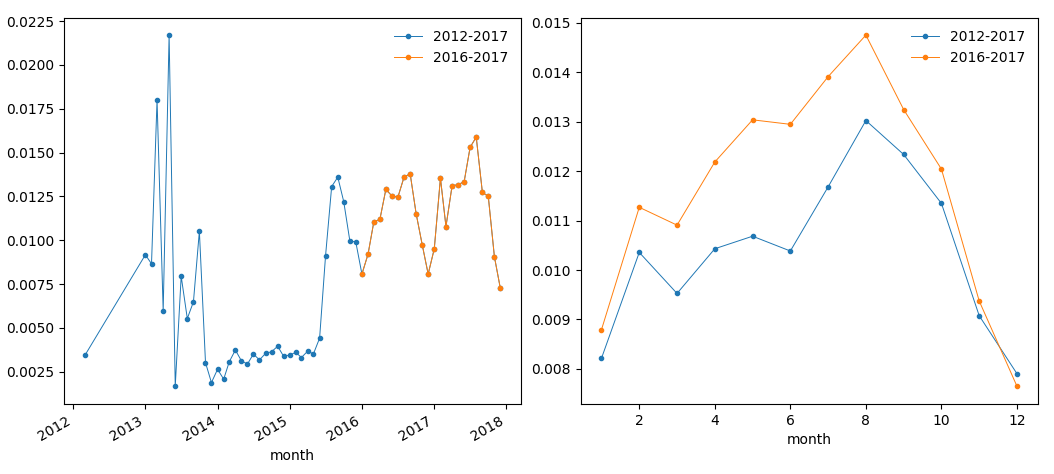

In [226]:
fig, ax = plt.subplots(ncols=2, figsize=(12,5))

month = data.groupby(data.index).sum()
month['rat_pct'] = month.num_rats / month.num_complaints
month['rat_pct'].plot(ax=ax[0], marker='.', lw=0.7,label='2012-2017')

month = data['2016':'2017'].groupby(data['2016':'2017'].index).sum()
month['rat_pct'] = month.num_rats / month.num_complaints
month['rat_pct'].plot(ax=ax[0], marker='.', lw=0.7,label='2016-2017')

monthyear = data.groupby(data.index.month).sum()
monthyear['rat_pct'] = monthyear.num_rats / monthyear.num_complaints
monthyear['rat_pct'].plot(ax=ax[1], marker='.', lw=0.7,label='2012-2017')

monthyear = data['2016':'2017'].groupby(data['2016':'2017'].index.month).sum()
monthyear['rat_pct'] = monthyear.num_rats / monthyear.num_complaints
monthyear['rat_pct'].plot(ax=ax[1], marker='.', lw=0.7, label='2016-2017')

ax[0].legend(frameon=False)
ax[1].legend(frameon=False)

plt.tight_layout()

In [227]:
total_zcta = data.groupby('zcta').sum()
total_zcta = total_zcta[total_zcta.num_complaints>100]
total_zcta['rat_pct'] = total_zcta.num_rats/total_zcta.num_complaints
total_zcta.reset_index(inplace=True)

In [228]:
total_zcta

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defaultColumnWidth': 150, 'rowHeight': 28, 'enableColumnReorder': False, 'enableTextSelectionOnCells': True, 'editable': True, 'autoEdit': False, 'explicitInitialization': True, 'maxVisibleRows': 15, 'minVisibleRows': 8, 'sortable': True, 'filterable': True, 'highlightSelectedCell': False, 'highlightSelectedRow': True}, precision=5)

In [229]:
def make_map(zip_data):
    lat_init, long_init = utils.lat_long('3 washington square village NYC')
    ny_map = folium.Map(location=[lat_init, long_init],
                        width='90%', height='100%',
                        tiles='Stamen Toner',
                         zoom_start=14)

    ny_map.choropleth(geo_data='/scratch/rag394/data/geospatial/nyu.json',
                      data=zip_data,
                      columns=['zcta', 'rat_pct'],
                      #threshold_scale=range(0,41,10),
                      key_on='feature.properties.zcta',
                      fill_color='YlGnBu',
                      legend_name='number rats')

    return ny_map

In [230]:
make_map(total_zcta)